Correlate similarity of multiple ligands for the same target

Choose targets that are quite common

e.g HIV-1 protease inhibitors, carbonic anhydrase inhibitors, etc.

In [8]:
import os
import sys

# Get the current notebook's directory
current_directory = os.getcwd()

# Get the parent directory
parent_directory = os.path.dirname(os.path.dirname(current_directory))

# Add the parent directory to the module search path
sys.path.insert(0, parent_directory)
print(parent_directory)

/n/holylabs/LABS/mzitnik_lab/Users/afang/GET


In [9]:
from data.converter.pdb_to_list_blocks import pdb_to_list_blocks
from data.converter.sm_pdb_to_blocks import sm_pdb_to_blocks
from data.dataset import VOCAB
from data.dataset import blocks_interface, blocks_to_data
from data.dataset import BlockGeoAffDataset, PDBBindBenchmark, DynamicBatchWrapper
from data.atom3d_dataset import LBADataset
import models
import torch
from trainers.abs_trainer import Trainer
import importlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from models import DenoisePretrainModel, AffinityPredictor
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import itertools
import random

/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
def get_tanimoto_similarity(pdb1, pdb2):
    # Load molecules from Mol2 files
    mol1 = Chem.MolFromMol2File(f"/n/holyscratch01/mzitnik_lab/afang/data/pdbbind/PDBbind_v2020_PL_refined/refined-set/{pdb1}/{pdb1}_ligand.mol2")
    mol2 = Chem.MolFromMol2File(f"/n/holyscratch01/mzitnik_lab/afang/data/pdbbind/PDBbind_v2020_PL_refined/refined-set/{pdb2}/{pdb2}_ligand.mol2")

    # Generate fingerprints (e.g., Morgan fingerprints with radius 2)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2)

    # Calculate Tanimoto similarity
    tanimoto_similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
    return tanimoto_similarity

In [11]:
dataset = LBADataset("/n/holylabs/LABS/mzitnik_lab/Users/afang/GET/datasets/LBA/split-by-sequence-identity-30/train")

fragmentation False
2024-02-13 11:34:14::INFO::Loading preprocessed data from /n/holylabs/LABS/mzitnik_lab/Users/afang/GET/datasets/LBA/split-by-sequence-identity-30/train.LBADataset_processed.pkl...


In [12]:
with open("hiv_protease.txt", "r") as f:
    hiv_protease = f.read().split("\n")
len(set(hiv_protease))

293

In [13]:
# given a list of pdb files get the chain using BioPython
from Bio.PDB import PDBParser
from collections import defaultdict

def get_pdb_path(pdb_id):
    return f"/n/holyscratch01/mzitnik_lab/afang/data/pdbbind/PDBbind_v2020_PL_refined/refined-set/{pdb_id}/{pdb_id}_pocket.pdb"

chains = defaultdict(list)
for pdbid in hiv_protease:
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("test", get_pdb_path(pdbid))
    chain = [ch.id for ch in structure.get_chains()][0]
    chains[chain].append(pdbid)

for k, v in chains.items():
    print(k, len(v))

hiv_protease = chains["A"]

A 284
B 9


In [14]:
hiv_dataset = []
for d in dataset:
    if d["id"] not in hiv_protease:
        continue
    hiv_dataset.append(d)
len(hiv_dataset)

284

In [15]:
pretrain_ckpt = "/n/holyscratch01/mzitnik_lab/afang/GET/datasets/LBA/split-by-sequence-identity-30/models/InteractNN/version_89/checkpoint/epoch69_step29470.ckpt" # finetuned from QBioLIP
model: AffinityPredictor = torch.load(pretrain_ckpt, map_location='cpu')
model = model.to("cuda")

In [16]:
embeddings = {}
pred_labels = {}
true_labels = {}
batch_size = 8
for i in range(0, len(hiv_dataset), batch_size):
    model.eval()
    with torch.no_grad():
        minibatch = LBADataset.collate_fn(hiv_dataset[i:i+batch_size])
        pdb_ids = [d["id"] for d in hiv_dataset[i:i+batch_size]]
        minibatch = Trainer.to_device(minibatch, "cuda")
        pred_binding_affinity, output = model.infer(minibatch, extra_info=True)
        for idx, pdb_id in enumerate(pdb_ids):
            embeddings[pdb_id] = output.graph_repr[idx].cpu().numpy()
            pred_labels[pdb_id] = pred_binding_affinity[idx].cpu().numpy()
            true_labels[pdb_id] = minibatch["label"][idx].cpu().numpy()

In [17]:
pairs = list(itertools.combinations(hiv_protease, 2))
subsample_pairs = random.sample(pairs, 500)

In [18]:
tani_similarities = []
for p1, p2 in subsample_pairs:
    tani = get_tanimoto_similarity(p1, p2)
    tani_similarities.append(tani)

# How does distance in the embedding space correlate to distance in the chemical space? 
For HIV protease inhibitors, we will use the Tanimoto similarity to calculate the similarity between ligands.

correlation coeff: 0.24937422761029818


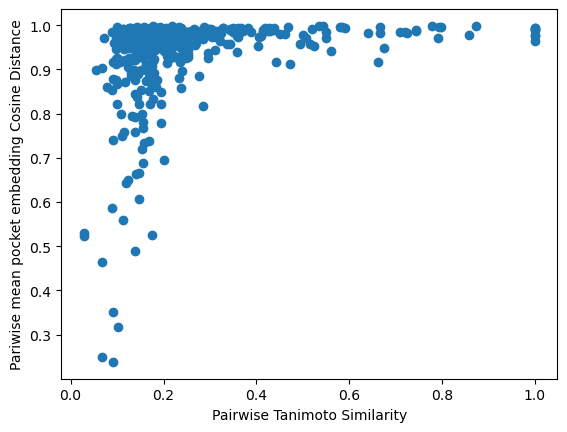

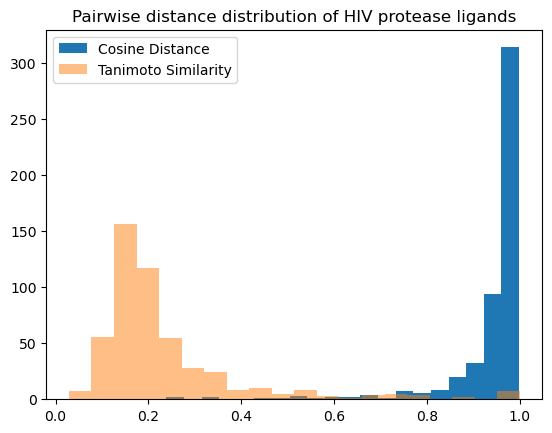

In [19]:
dsim_similarities = []
for p1, p2 in subsample_pairs:
    dsim = np.dot(embeddings[p1], embeddings[p2]) / (np.linalg.norm(embeddings[p1]) * np.linalg.norm(embeddings[p2]))
    dsim_similarities.append(dsim)
plt.scatter(tani_similarities, dsim_similarities)
plt.xlabel("Pairwise Tanimoto Similarity")
plt.ylabel("Pariwise mean pocket embedding Cosine Distance")
print(f"correlation coeff: {np.corrcoef(tani_similarities, dsim_similarities)[0][1]}")
plt.show()

plt.hist(dsim_similarities, bins=20, label = "Cosine Distance")
plt.hist(tani_similarities, bins=20, alpha=0.5, label = "Tanimoto Similarity")
plt.legend()
plt.title("Pairwise distance distribution of HIV protease ligands")
plt.show()

correlation coeff: -0.3124552700651781


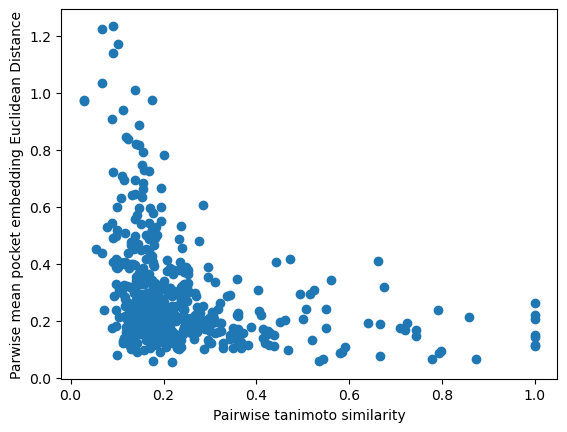

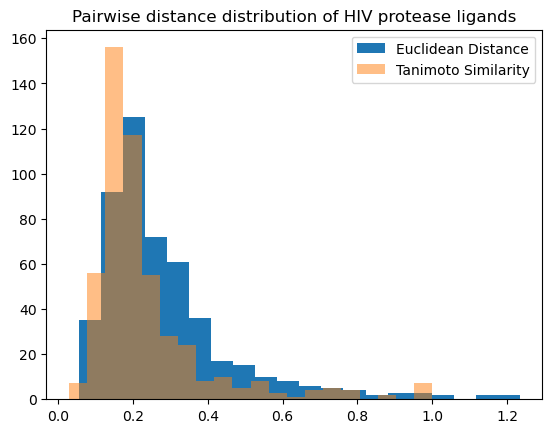

In [20]:
dsim_similarities = []
for p1, p2 in subsample_pairs:
    dsim = np.linalg.norm(embeddings[p1] - embeddings[p2])
    dsim_similarities.append(dsim)
plt.scatter(tani_similarities, dsim_similarities)
plt.xlabel("Pairwise tanimoto similarity")
plt.ylabel("Parwise mean pocket embedding Euclidean Distance")
print(f"correlation coeff: {np.corrcoef(tani_similarities, dsim_similarities)[0][1]}")
plt.show()

plt.hist(dsim_similarities, bins=20, label = "Euclidean Distance")
plt.hist(tani_similarities, bins=20, alpha=0.5, label = "Tanimoto Similarity")
plt.legend()
plt.title("Pairwise distance distribution of HIV protease ligands")
plt.show()

# How does distance in the chemical space correlate to binding affinity? 
For HIV protease inhibitors, we will use the Tanimoto similarity to calculate the similarity between ligands.

correlation coeff: 0.06940764834790562


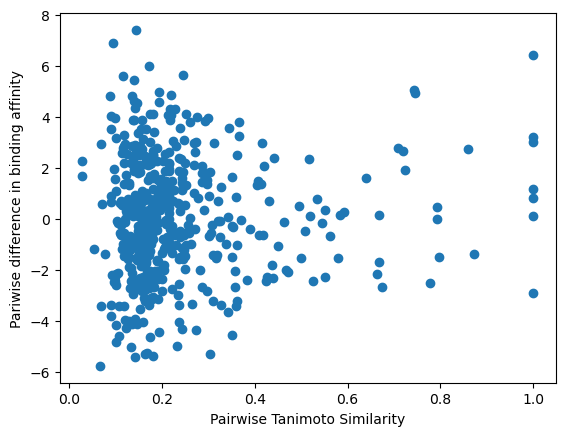

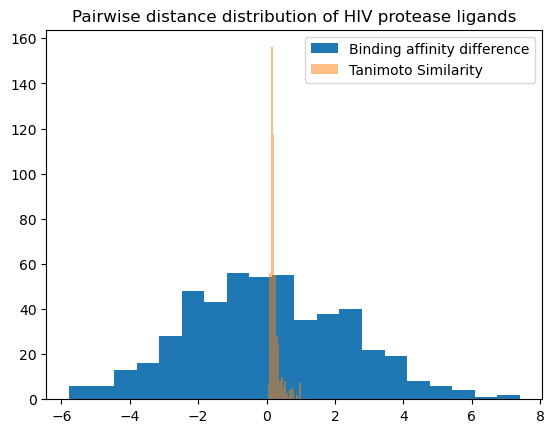

In [21]:
dsim_similarities = []
for p1, p2 in subsample_pairs:
    dsim = true_labels[p1] - true_labels[p2]
    dsim_similarities.append(dsim)
plt.scatter(tani_similarities, dsim_similarities)
plt.xlabel("Pairwise Tanimoto Similarity")
plt.ylabel("Pariwise difference in binding affinity")
print(f"correlation coeff: {np.corrcoef(tani_similarities, dsim_similarities)[0][1]}")
plt.show()

plt.hist(dsim_similarities, bins=20, label = "Binding affinity difference")
plt.hist(tani_similarities, bins=20, alpha=0.5, label = "Tanimoto Similarity")
plt.legend()
plt.title("Pairwise distance distribution of HIV protease ligands")
plt.show()